### 1.1 引入相关包与设置参数

In [6]:
# -*-coding:utf-8 -*-
import pandas as pd 
import numpy as np
import seaborn as sns
import arrow as ar
import matplotlib.pyplot as plt
%matplotlib inline 
#设置ipython显示
import warnings
warnings.filterwarnings("ignore") #消除警告语
import os
os.chdir('H:/file_for_git')

### 1.2 数据读入与前处理

In [96]:
#利用usecols与nrows取出需要处理的行列,减少内存消耗,有时encoding使用gbk避免中文读入错误
data1=pd.read_csv(r'./data/data_ori1.csv',usecols=[0,1,2,3,4],nrows=100000,encoding='utf-8')
data2=pd.read_csv(r'./data/data_ori2.csv',usecols=[0,1,2,3,4],nrows=100000,encoding='utf-8')

* 数据概览

In [29]:
data1.head(5)

,msno,payment_method_id,payment_plan_days
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30


* 分位数与基本统计

In [30]:
data1.describe()

,payment_method_id,payment_plan_days
count,100000.000000,100000.000000
mean,38.927820,31.490240
std,3.517666,31.055404
min,2.000000,0.000000
25%,38.000000,30.000000
50%,41.000000,30.000000
75%,41.000000,30.000000
max,41.000000,450.000000


* 数据结构与内存占用

In [35]:
data1.info()
data1.memory_usage()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
msno                 100000 non-null object
payment_method_id    100000 non-null int64
payment_plan_days    100000 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


Index                    80
msno                 800000
payment_method_id    800000
payment_plan_days    800000
dtype: int64

* 根据行列的位置取数据

In [32]:
data1.iloc[0:5,[0,1]]

,msno,payment_method_id
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39


* 内存压缩

In [41]:
#手动方式,根据数据大小设定
print (data1['payment_method_id'].max())
print (data1['payment_method_id'].min())
data1['payment_method_id'] = data1['payment_method_id'].astype(np.uint8)

41
2


In [45]:
#对于有负值和小数的情况,保留有效数字然后转换
data1['payment_method_id'] = data1['payment_method_id'].round(2).astype(np.float16)

In [77]:
#自动方式
def reduce_mem(pandas_obj):
    before=pandas_obj.memory_usage(index=True).sum()/1024**2
    print ('before {:.1f} MB'.format(before))
    gl_obj = pandas_obj.select_dtypes(include=['object'])
   
    gl_int = pandas_obj.select_dtypes(include=['int'])
    converted_int = gl_int.apply(pd.to_numeric,downcast='unsigned')
   
    gl_float = pandas_obj.select_dtypes(include=['float'])
    converted_float = gl_float.apply(pd.to_numeric,downcast='unsigned')
    
    pandas_new=pd.concat([gl_obj,converted_int,converted_float],axis=1)
    after=pandas_new.memory_usage(index=True).sum()/1024**2
    print ('after {0:.2f} MB,reduce {1:.1f} percent'.format(after,100*(1-after/before)))
    return pandas_new

data1=reduce_mem(data1)

before 22.9 MB
after 7.63 MB,reduce 66.7 percent


* 缺失值探索

In [81]:
data1.isnull().sum()

msno                  0
payment_method_id     0
payment_plan_days     0
plan_list_price       0
actual_amount_paid    0
dtype: int64

In [82]:
#树类模型可进行区分值填充
data1=data1.fillna(-1)

* 离散值探索

In [91]:
cate_fea=data1['payment_method_id'].value_counts()/len(data1)
cate_fea.head(5)

41    0.53499
40    0.10256
38    0.07919
39    0.06805
37    0.04693
Name: payment_method_id, dtype: float64

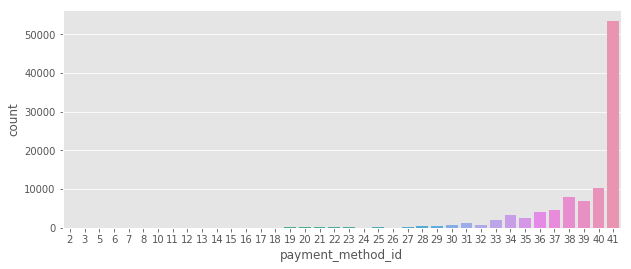

In [95]:
plt.style.use('ggplot')
plt.figure(figsize=(10,4))
sns.countplot(x='payment_method_id',data=data1)

In [90]:
cate_fea

41    0.53499
40    0.10256
38    0.07919
39    0.06805
37    0.04693
36    0.03990
34    0.03395
35    0.02501
33    0.01918
31    0.01158
30    0.00751
32    0.00683
29    0.00547
28    0.00441
27    0.00254
23    0.00205
19    0.00151
20    0.00137
21    0.00126
22    0.00102
25    0.00082
24    0.00075
14    0.00068
18    0.00066
16    0.00039
17    0.00038
13    0.00032
26    0.00018
12    0.00017
11    0.00009
15    0.00006
7     0.00005
10    0.00003
8     0.00003
3     0.00003
6     0.00002
5     0.00002
2     0.00001
Name: payment_method_id, dtype: float64